In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
Y_train = []
def data_train(path):
    df = pd.read_csv(path,header=0,parse_dates=[1,4,6])
    Y_train = df['Fare']
    return df,Y_train

def data_test(path):
    df = pd.read_csv(path,header=0,parse_dates=[1,4,6])
    return df

In [4]:
df_train, Y_train = data_train("./train.csv")
df_test = data_test("./test.csv")
df_train

,Name,Date of Birth,From,To,Flight Date,Flight Time,Booking Date,Class,Fare
0,Dr. FG61 FS88,1963-10-23,Mumbai,Kolkata,2016-11-04,13:50,2016-10-19,Business,14737.67
1,Dr. FG35 FS74,1981-10-09,Lucknow,Hyderabad,2016-09-19,18:30,2016-07-31,Economy,7621.71
2,Dr. MG45 MS99,1981-07-09,Lucknow,Patna,2016-05-27,10:50,2016-05-24,Economy,5655.81
3,Mr. MG93 MS13,1988-09-08,Mumbai,Lucknow,2016-07-24,14:40,2016-07-16,Economy,7436.94
4,Miss FG28 FS14,1994-11-18,Kolkata,Delhi,2016-12-21,10:20,2016-12-09,Economy,3282.54
...,...,...,...,...,...,...,...,...,...
7495,Mrs. FG69 FS91,1978-12-26,Lucknow,Mumbai,2016-03-02,17:50,2016-02-22,Business,14213.52
7496,Mr. MG86 MS11,1953-07-27,Mumbai,Chennai,2016-12-26,17:50,2016-12-25,Economy,6629.28
7497,Miss FG41 FS40,1988-06-16,Kolkata,Mumbai,2016-01-20,07:10,2016-01-16,Business,14854.97
7498,Miss FG66 FS27,2001-06-28,Lucknow,Patna,2016-03-10,11:20,2016-02-19,Economy,1634.57


In [5]:
holidays = ['2016-01-01','2016-01-14','2016-01-15','2016-01-16','2016-01-26','2016-02-12','2016-03-07','2016-03-23','2016-03-25','2016-03-27','2016-04-13','2016-04-15','2016-04-20','2016-04-21','2016-05-21','2016-07-08','2016-08-15','2016-08-18','2016-08-25','2016-09-05','2016-09-12','2016-09-14','2016-10-02','2016-10-11','2016-10-12','2016-10-30','2016-10-31','2016-11-01','2016-11-06','2016-11-24','2016-12-13','2016-12-24','2016-12-25']

In [6]:
import warnings

# To ignore all warnings
warnings.filterwarnings("ignore")

# Or, to filter specific warnings
warnings.filterwarnings("ignore")

df_train['diff'] = df_train['Flight Date'] - df_train['Booking Date']
df_test['diff'] = df_test['Flight Date'] - df_test['Booking Date']
df_train['diff'] = df_train['diff'] / np.timedelta64(1,'D')
df_test['diff'] = df_test['diff'] / np.timedelta64(1,'D')
df_train['age'] = df_train['Booking Date'] - df_train['Date of Birth']
df_train['age'] = df_train['age']/np.timedelta64(1,'D')
df_test['age'] = df_test['Booking Date'] - df_test['Date of Birth']
df_test['age'] = df_test['age']/np.timedelta64(1,'D')
df_test['age'] = df_test['age']/365
df_train['age'] = df_train['age']/365
df_train['flight_month'] = df_train['Flight Date'].dt.month
df_test['flight_month'] = df_test['Flight Date'].dt.month
df_train['WEEKDAY'] = df_train['Flight Date'].dt.dayofweek.astype(int)
df_test['WEEKDAY'] = df_train['Flight Date'].dt.dayofweek.astype(int)
df_test['WEEKEND'] = 0
df_train['WEEKEND'] = 0
df_train['FLIGHTWEEK'] = df_train['Flight Date'].dt.week
df_test['FLIGHTWEEK'] = df_test['Flight Date'].dt.week
## WEEKEND - 18:00, FRIDAY to 23:59, SUNDAY (considering office hours)
def label_holiday (row):
    if str(row['Flight Date']) in holidays :
        return 2
    else:
        return 0
df_train['WEEKEND'] = df_train.apply(lambda row: label_holiday(row), axis=1)
df_test['WEEKEND'] = df_test.apply(lambda row: label_holiday(row), axis=1)
def is_weekend(df):
    for i in range(0,len(df)):
        if df['WEEKDAY'][i] == 0 or df['WEEKDAY'][i] == 1 or df['WEEKDAY'][i] == 2 or df['WEEKDAY'][i] == 3:
            df['WEEKEND'][i] = 0
        elif df['WEEKDAY'][i] == 5 or df['WEEKDAY'][i] == 6:
            df['WEEKEND'][i] = 1
        elif df['WEEKDAY'][i] == 4:
            flight_time = pd.to_datetime(df['Flight Time'][i], format='%H:%M')
            threshold_time = pd.to_datetime('18:00', format='%H:%M')
            if flight_time>threshold_time:
                df['WEEKEND'][i] = 1
            else:
                df['WEEKEND'][i] = 0

is_weekend(df_train)
is_weekend(df_test)


In [7]:
dict_cities = {'Mumbai':1 , 'Patna' : 2, 'Kolkata' : 3, 'Delhi' : 4, 'Hyderabad': 5, 'Lucknow': 6, 'Chennai':7}
dict_class = {'Business':3.6, 'Economy': 1} # Price ratio of business and economy class
df_train = df_train.replace({'From':dict_cities})
df_test = df_test.replace({'From':dict_cities})
df_train = df_train.replace({'To': dict_cities})
df_test = df_test.replace({'To': dict_cities})
df_train = df_train.replace({'Class':dict_class})
df_test = df_test.replace({'Class':dict_class})

In [8]:
df_train['Name'] = df_train['Name'].str.split('.').str[0]
df_test['Name'] = df_test['Name'].str.split('.').str[0]
def label_gender (row):
    if 'Dr' in row['Name']:
        return 4
    if 'Miss' in row['Name']:
        return 0
    if 'Mrs' in row['Name']:
        return 1
    if 'Mr' in row['Name']:
        return 3
    return None

df_train['gender'] = df_train.apply (lambda row: label_gender (row),axis=1)
df_test['gender'] = df_test.apply (lambda row: label_gender (row),axis=1)
df_train= df_train.drop(columns='Name')
df_test = df_test.drop(columns='Name')
df_train =df_train.drop(columns='Fare')
df_train['Flight Time'] = df_train['Flight Time'].str.split(':').str[0]
df_test['Flight Time'] = df_test['Flight Time'].str.split(':').str[0]
df_train['Flight Time'] = df_train['Flight Time'].astype(str).astype(int)
df_test['Flight Time'] = df_test['Flight Time'].astype(str).astype(int)

In [9]:
time_from = {}
time_from['1'] = [0,130,140,120,75,130,89]
time_from['2'] = [205,0,60,95,104,39,134]
time_from['3'] = [155,90,0,120,120,105,135]
time_from['4'] = [115,80,115,0,120,55,155]
time_from['5'] = [70,104,115,125,0,235,65]
time_from['6'] = [130,39,100,60,245,0,138]
time_from['7'] = [95,134,115,155,65,138,0]


In [10]:
def label_duration (row):
    return time_from[str(int(row['From']))][int(row['To'])-1]

def label_distance (row):
   if (row['From'] == 1 and row['To'] == 2) or (row['From'] == 2 and row['To'] == 1):
        return 1446
   if (row['From'] == 1 and row['To'] == 3) or (row['From'] == 3 and row['To'] == 1):
        return 1654
   if (row['From'] == 1 and row['To'] == 4) or (row['From'] == 4 and row['To'] == 1):
        return 1148
   if (row['From'] == 1 and row['To'] == 5) or (row['From'] == 5 and row['To'] == 1):
        return 622
   if (row['From'] == 1 and row['To'] == 6) or (row['From'] == 6 and row['To'] == 1):
        return 1190
   if (row['From'] == 1 and row['To'] == 7) or (row['From'] == 7 and row['To'] == 1):
        return 1028
   if (row['From'] == 2 and row['To'] == 3) or (row['From'] == 3 and row['To'] == 2):
        return 470
   if (row['From'] == 2 and row['To'] == 4) or (row['From'] == 4 and row['To'] == 2):
        return 480
   if (row['From'] == 2 and row['To'] == 5) or (row['From'] == 5 and row['To'] == 2):
        return 1140
   if (row['From'] == 2 and row['To'] == 6) or (row['From'] == 6 and row['To'] == 2):
        return 437
   if (row['From'] == 2 and row['To'] == 7) or (row['From'] == 7 and row['To'] == 2):
        return 1485
   if (row['From'] == 3 and row['To'] == 4) or (row['From'] == 4 and row['To'] == 3):
        return 1307
   if (row['From'] == 3 and row['To'] == 5) or (row['From'] == 5 and row['To'] == 3):
        return 1180
   if (row['From'] == 3 and row['To'] == 6) or (row['From'] == 6 and row['To'] == 3):
        return 886
   if (row['From'] == 3 and row['To'] == 7) or (row['From'] == 7 and row['To'] == 2):
        return 1366
   if (row['From'] == 4 and row['To'] == 5) or (row['From'] == 5 and row['To'] == 4):
        return 1253
   if (row['From'] == 4 and row['To'] == 6) or (row['From'] == 6 and row['To'] ==  4):
        return 417
   if (row['From'] == 4 and row['To'] == 7) or (row['From'] == 7 and row['To'] == 4):
        return 1760
   if (row['From'] == 5 and row['To'] == 6) or (row['From'] == 6 and row['To'] == 5):
        return 1425
   if (row['From'] == 5 and row['To'] == 7) or (row['From'] == 7 and row['To'] == 5):
        return 520
   if (row['From'] == 6 and row['To'] == 7) or (row['From'] == 7 and row['To'] == 6):
        return 1534
   return None

In [11]:
df_train['flight_duration'] = df_train.apply (lambda row: label_duration (row),axis=1)
df_test['flight_duration'] = df_test.apply (lambda row: label_duration (row),axis=1)
df_train['distance'] = df_train.apply (lambda row: label_distance (row),axis=1)
df_test['distance'] = df_test.apply (lambda row: label_distance (row),axis=1)
df_train['avg speed'] = df_train['distance']/df_train['flight_duration']
df_test['avg speed'] = df_test['distance']/df_test['flight_duration']


In [12]:
df_train = df_train.drop(columns=['Date of Birth', 'Booking Date','Flight Date','distance','flight_duration'])
df_test = df_test.drop(columns=['Date of Birth', 'Booking Date','Flight Date','distance','flight_duration'])
df_train

,From,To,Flight Time,Class,diff,age,flight_month,WEEKDAY,WEEKEND,FLIGHTWEEK,gender,avg speed
0,1,3,13,3.6,16.0,53.027397,11,4,0,44,4,11.814286
1,6,5,18,1.0,50.0,34.832877,9,0,0,38,4,5.816327
2,6,2,10,1.0,3.0,34.898630,5,4,0,21,4,11.205128
3,1,6,14,1.0,8.0,27.871233,7,6,1,29,3,9.153846
4,3,4,10,1.0,12.0,22.073973,12,2,0,51,0,10.891667
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,6,1,17,3.6,9.0,37.183562,3,2,0,9,1,9.153846
7496,1,7,17,1.0,1.0,63.457534,12,0,0,52,3,11.550562
7497,3,1,7,3.6,4.0,27.602740,1,2,0,3,0,10.670968
7498,6,2,11,1.0,20.0,14.654795,3,3,0,10,0,11.205128


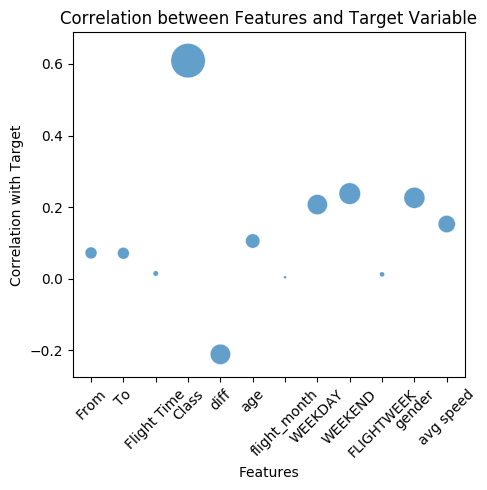

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
correlations = df_train.corrwith(Y_train)
plt.figure(figsize=(5, 5))
sns.scatterplot(x=correlations.index, y=correlations.values, s=correlations.abs()*1000, alpha=0.7)
plt.title('Correlation between Features and Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
df_train.drop(columns=['FLIGHTWEEK','Flight Time'])

,From,To,Class,diff,age,flight_month,WEEKDAY,WEEKEND,gender,avg speed
0,1,3,3.6,16.0,53.027397,11,4,0,4,11.814286
1,6,5,1.0,50.0,34.832877,9,0,0,4,5.816327
2,6,2,1.0,3.0,34.898630,5,4,0,4,11.205128
3,1,6,1.0,8.0,27.871233,7,6,1,3,9.153846
4,3,4,1.0,12.0,22.073973,12,2,0,0,10.891667
...,...,...,...,...,...,...,...,...,...,...
7495,6,1,3.6,9.0,37.183562,3,2,0,1,9.153846
7496,1,7,1.0,1.0,63.457534,12,0,0,3,11.550562
7497,3,1,3.6,4.0,27.602740,1,2,0,0,10.670968
7498,6,2,1.0,20.0,14.654795,3,3,0,0,11.205128


In [15]:
!pip3 install xgboost

In [16]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor(max_depth = 20,objective='reg:linear',n_estimators=500)
xgb.fit(df_train,Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=20, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [17]:
xgb.score(df_train,Y_train)

0.9999999999999706

In [18]:
df_train.drop(columns=['FLIGHTWEEK','Flight Time'])
df_test

,From,To,Flight Time,Class,diff,age,flight_month,WEEKDAY,WEEKEND,FLIGHTWEEK,gender,avg speed
0,4,6,19,1.0,47.0,11.652055,4,4,1,14,0,7.581818
1,6,4,17,1.0,43.0,54.775342,3,0,0,10,4,6.950000
2,6,4,13,3.6,13.0,49.369863,1,4,0,2,4,6.950000
3,6,1,13,1.0,31.0,58.517808,10,6,1,41,4,9.153846
4,7,4,17,1.0,21.0,16.600000,9,2,0,38,0,11.354839
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,7,1,11,1.0,8.0,60.150685,5,5,1,20,3,10.821053
2496,6,1,20,3.6,11.0,37.290411,7,6,1,27,4,9.153846
2497,4,7,16,1.0,43.0,12.715068,7,2,0,26,3,11.354839
2498,6,4,2,3.6,14.0,55.142466,1,6,1,2,4,6.950000


In [19]:
xgb_final_preds = xgb.predict(df_test)
np.savetxt('pred_testdata.csv',xgb_final_preds,delimiter = ',')

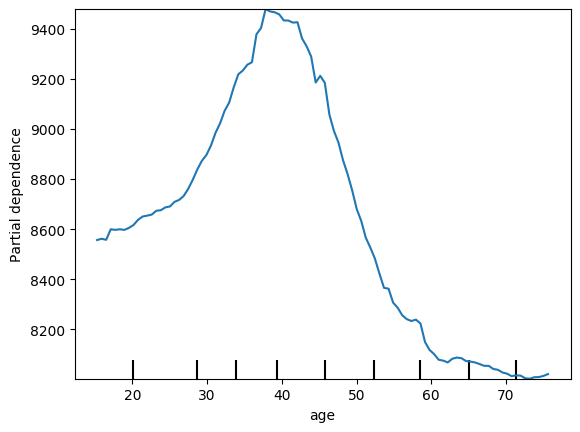

In [20]:
import sklearn
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(estimator=xgb,X=df_train,features=['age'])